# Cohort 60x60 AUCs analysis

### Imports and environment setup

- Date of run: 2024-08-13
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file (available [here](<https://mimarkdx.sharepoint.com/sites/Scientific/Documentos compartidos/General/PHASE 6 - SOFTWARE DEVELOPMENT/DATA/../../../../../../:x:/s/Scientific/Eaw9d-fa2BREg_iZB1SL02YBG4mfVaJtoylG46bROmXVJA?e=8chcN7>)) was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [4]:
df_120 = pd.read_csv('../data/ruo_vs_mmk_20240723.csv' , sep='\t', index_col=0, header=0)


In [5]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)

In [6]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL', 'pH',
                    'MMP9_RUO', 'HSPB1_RUO', 'PERM_RUO',
                    'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK',
                    'KPYM_MMK', 'PERM_MMK', 'Total_protein_UCFP',
                    'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

In [7]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

# Execution parameters

In [8]:
PLOT_ROCS = True
MAX_BIOMARKER_COUNT = 3
RESULTS_PATH = '../data/results/60x60'

# Columns to be considered as biomarkers
BIOMARKERS_120 = ['MMP9_RUO', 'HSPB1_RUO', 'PERM_RUO', 'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK', 'KPYM_MMK', 'PERM_MMK']

NORMALIZING_COL_120 = 'Total_protein_BCA' # Column to be used for normalizing the biomarkers
VOLUME_COL = 'Collected_volume_mL' # Column to be used as volume for scatters and undoing the dilution

## Methods

Description of the methods used to compute the AUCS

### Direct

No transformations were made to the readout of each biomarker.

Due to the different treatment the samples have undergone, the performance of the biomarkers in the 60x60 is masking the correlation of the target variable (disease) with the volume variable because the biomarkers (and total protein) readouts correlate with the collected volume. While the volume is a good classification variable, we want to get rid of it because we cannot control it.  

### Normalized

To get rid of the volume, the total protein variable was proposed as a normalizing variable. The values used for classification are then the ratios of the concentrations $[Bmk]/[TP]$.

About the pros and cons of this method: 
- As a pro, the total protein correlates with the volume (in the 60x60 cohort) so normalizing by it allows to get rid of the volume. 
- Total protein (unlike volume) is determined experimentally and not manually and is not extraction/technician/clinician dependent.  
- While it correlates with the volume (in the 60x60 cohort), the concentration of total protein is a variable itself. It could be explained to some extent by the volume but also by other causes, then using it as a means of getting rid of the volume could come at the price of adding a biological interpretation layer to the results. 
- After discussions with the collaborators from Santiago, they noted the fact that ratios can be misleading, especially if the denominator variable is not independent of the numerator or other variables in the analysis. 

### Kronmal

The last bullet point of the previous section was remarked by our collaborators. We have then computed the performance of the biomarkers with the Kronmal’s method, which consists of adding the normalizing variable ($[Total Protein]$) as a new variable in the model. 

This method has the cons of adding the $[TP]$ to the model, making the result harder to interpret and not solving the volume correlation nor for the $[TP]$ neither for the biomarkers. 


### Undo dilution

In this method, to undo the dilution and use the samples expressed in the concentration they had in terms of their collected volume, we have applied the rule of three: 

$f.v.\to [BMK]_{f.v.}$

$c.v. \to [BMK]_{c.v.} = \frac{c.v.}{f.v.} * [BMK]_{f.v.}$


In the 240 cohort this method will have the same performance as the direct method since $c.v./f.v.$ will be always a constant (½) affecting equally all the observations. For the 60x60 cohort, the $f.v.$ is $c.v.+0.5mL$, making the ratio close to one for bigger volumes and closer to zero for smaller ones. Said that, only results for the 60x60 cohort are presented: 

In [9]:
METHODS = ['direct', 'normalized', 'kronmal', 'undo_dilution']

# Computing the models

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

In [ ]:
models_120 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            )

Let's do the same for single biomarkers.

In [10]:
MAX_BIOMARKER_COUNT = 1

models_120_1 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            compute_auc_ci=True
                            )

## Running other analyses

### Create scatterplots for all the pairs of biomarkers

In [ ]:
for biomarker1 in BIOMARKERS_120:
    for biomarker2 in BIOMARKERS_120[BIOMARKERS_120.index(biomarker1)+1:]:
        utils.plot_scatter_to_file(df_120, 
                                biomarker1, 
                                biomarker2, 
                                normalizing_col=NORMALIZING_COL_120, 
                                apply_log_x=True,
                                apply_log_y=True,
                                hue='Pathology', 
                                folder=RESULTS_PATH+'/scatters/')

### Create scatterplots for all the [biomarkers] & [Total protein] readouts versus collected volume 

In [ ]:
for biomarker1 in BIOMARKERS_120+['Total_protein_BCA']:
        utils.plot_scatter_to_file(df_120, 
                                biomarker1, 
                                VOLUME_COL, 
                                normalizing_col=None, 
                                apply_log_x=True,
                                apply_log_y=False,
                                hue='Pathology', 
                                folder=RESULTS_PATH+'/volume_scatters/diluted/')

### Undilute all the [biomarkers] & [Total protein] readouts and create scatterplots versus collected volume 

In [ ]:
df_120_undiluted = df_120.copy()
df_120_undiluted['Final_volume'] = df_120_undiluted['Collected_volume_mL'] + 0.5
for col in BIOMARKERS_120+['Total_protein_BCA', 'Total_protein_UCFP']:
    df_120_undiluted[col] = df_120_undiluted[col].multiply(df_120_undiluted['Final_volume'].div(df_120_undiluted['Collected_volume_mL'], axis=0), axis=0)
        


In [ ]:
for biomarker1 in BIOMARKERS_120+['Total_protein_BCA']:
        utils.plot_scatter_to_file(df_120_undiluted, 
                                biomarker1, 
                                VOLUME_COL, 
                                normalizing_col=None, 
                                apply_log_x=True,
                                apply_log_y=False,
                                hue='Pathology', 
                                folder=RESULTS_PATH+'/volume_scatters/undiluted/')

# Results

## Direct

Here are presented the top 10 results for the direct method. Remember you can see the full results [here](<../data/results/60x60/direct/max_3.csv>) (they are stored in the folder "data/results/60x60/direct/").

In [ ]:
df_results_120_direct = pd.read_csv(RESULTS_PATH+'/direct/max_3.csv', sep=',', header=0)
df_results_120_direct[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)


,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,PERM_RUO,AGRIN_MMK,NaN,0.86329
1,AGRIN_MMK,NaN,NaN,0.83556
2,PERM_RUO,NaN,NaN,0.83322
3,MMP9_RUO,PERM_RUO,AGRIN_MMK,0.82910
4,MMP9_MMK,NaN,NaN,0.82611
5,PERM_MMK,NaN,NaN,0.81925
6,MMP9_RUO,PERM_RUO,NaN,0.81713
7,MMP9_RUO,NaN,NaN,0.81404
8,MMP9_RUO,AGRIN_MMK,NaN,0.79064
9,MMP9_MMK,HSPB1_MMK,AGRIN_MMK,0.76667


Let's see also how the biomarkers performed individually.

In [ ]:
df_results_120_direct[df_results_120_direct['Biomarker_2'].isnull() & df_results_120_direct['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
1,AGRIN_MMK,0.83556
2,PERM_RUO,0.83322
4,MMP9_MMK,0.82611
5,PERM_MMK,0.81925
7,MMP9_RUO,0.81404
10,HSPB1_MMK,0.76384
16,KPYM_MMK,0.72056
35,HSPB1_RUO,0.68242


## Kronmal

In [ ]:
df_results_120_kronmal = pd.read_csv(RESULTS_PATH+'/kronmal/max_3.csv', sep=',', header=0)
df_results_120_kronmal[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)


,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,MMP9_RUO,PERM_RUO,AGRIN_MMK,0.82547
1,PERM_RUO,AGRIN_MMK,NaN,0.81783
2,PERM_MMK,NaN,NaN,0.81494
3,MMP9_RUO,PERM_RUO,NaN,0.81459
4,PERM_RUO,NaN,NaN,0.80175
5,MMP9_MMK,HSPB1_MMK,AGRIN_MMK,0.78446
6,MMP9_RUO,HSPB1_MMK,AGRIN_MMK,0.76577
7,PERM_RUO,HSPB1_MMK,AGRIN_MMK,0.76211
8,HSPB1_MMK,AGRIN_MMK,NaN,0.76045
9,HSPB1_MMK,AGRIN_MMK,KPYM_MMK,0.75989


In [ ]:
df_results_120_kronmal[df_results_120_kronmal['Biomarker_2'].isnull() & df_results_120_kronmal['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
2,PERM_MMK,0.81494
4,PERM_RUO,0.80175
12,AGRIN_MMK,0.73639
13,MMP9_RUO,0.72749
23,MMP9_MMK,0.68889
54,HSPB1_RUO,0.64727
63,KPYM_MMK,0.63361
68,HSPB1_MMK,0.60763


## Normalized

In [ ]:
df_results_120_normalized = pd.read_csv(RESULTS_PATH+'/normalized/max_3.csv', sep=',', header=0)
df_results_120_normalized[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)

,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,AGRIN_MMK,NaN,NaN,0.80361
1,MMP9_MMK,HSPB1_MMK,AGRIN_MMK,0.75169
2,MMP9_RUO,HSPB1_MMK,AGRIN_MMK,0.73958
3,HSPB1_MMK,AGRIN_MMK,NaN,0.73898
4,HSPB1_MMK,AGRIN_MMK,KPYM_MMK,0.73842
5,MMP9_RUO,AGRIN_MMK,NaN,0.73743
6,HSPB1_MMK,AGRIN_MMK,PERM_MMK,0.72764
7,PERM_RUO,AGRIN_MMK,NaN,0.72587
8,PERM_RUO,HSPB1_MMK,AGRIN_MMK,0.72472
9,MMP9_RUO,NaN,NaN,0.71111


In [ ]:
df_results_120_normalized[df_results_120_normalized['Biomarker_2'].isnull() & df_results_120_normalized['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
0,AGRIN_MMK,0.80361
9,MMP9_RUO,0.71111
10,MMP9_MMK,0.70500
11,PERM_MMK,0.68908
13,PERM_RUO,0.68392
14,KPYM_MMK,0.68361
18,HSPB1_MMK,0.67373
52,HSPB1_RUO,0.62455


## Undo dilution

In [ ]:
df_results_120_undo_dilution = pd.read_csv(RESULTS_PATH+'/undo_dilution/max_3.csv', sep=',', header=0)
df_results_120_undo_dilution[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)

,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,PERM_RUO,AGRIN_MMK,NaN,0.88385
1,MMP9_RUO,PERM_RUO,AGRIN_MMK,0.87360
2,PERM_RUO,NaN,NaN,0.86538
3,MMP9_RUO,PERM_RUO,NaN,0.86120
4,PERM_MMK,NaN,NaN,0.85077
5,AGRIN_MMK,NaN,NaN,0.84883
6,MMP9_RUO,AGRIN_MMK,NaN,0.84841
7,MMP9_MMK,NaN,NaN,0.84575
8,MMP9_RUO,NaN,NaN,0.82856
9,HSPB1_MMK,NaN,NaN,0.81129


In [ ]:
df_results_120_undo_dilution[df_results_120_undo_dilution['Biomarker_2'].isnull() & df_results_120_undo_dilution['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
2,PERM_RUO,0.86538
4,PERM_MMK,0.85077
5,AGRIN_MMK,0.84883
7,MMP9_MMK,0.84575
8,MMP9_RUO,0.82856
9,HSPB1_MMK,0.81129
50,HSPB1_RUO,0.73901
54,KPYM_MMK,0.73399


## ROC curves

All the ROC curves for all the methods over all the combinations in all the cohorts were computed. If you want to check any ROC curve, the folder structure is the following: "data/results/60x60/<method>/<max_biomarkers>/rocs/. 

What we have observed is that, if we set as a threshold 0.97 sensitivity, this comes at the price of poor specificity. Just as an example, let’s take a look to the best scored classifier of all the methods above: PERM_RUO & AGRIN_MMK using the ‘undo_dilution’ method. This ROC image is located at "data/results/60x60/undo_dilution/max_3/rocs/PERM_RUO_AGRIN_MMK.png". 

 

In [ ]:
roc_image_path = "../data/results/60x60/undo_dilution/max_3/rocs/PERM_RUO_AGRIN_MMK.png"
display(HTML("<img src='"+roc_image_path+"'>"))


All the sensitivities and specificities for all the tresholds are located in the same folder, in CSV files.


In [ ]:
roc_table_path = "../data/results/60x60/undo_dilution/max_3/rocs/PERM_RUO_AGRIN_MMK.csv"
roc_table = pd.read_csv(roc_table_path, sep=',', header=0)
roc_table


,Threshold,Sensitivity,Specificity,NPV,PPV
0,inf,0.00,1.000000,0.509804,0.000000
1,0.670691,0.02,1.000000,0.514851,1.000000
2,0.659550,0.08,1.000000,0.530612,1.000000
3,0.656151,0.08,0.961538,0.520833,0.666667
4,0.639877,0.30,0.961538,0.588235,0.882353
5,0.636451,0.30,0.923077,0.578313,0.789474
6,0.631436,0.48,0.923077,0.648649,0.857143
7,0.630951,0.48,0.903846,0.643836,0.827586
8,0.624833,0.64,0.903846,0.723077,0.864865
9,0.624183,0.64,0.884615,0.718750,0.842105


## AUCs confidence interval

In [51]:
aucs = []
auc_cis = []
models = []

for model in models_120_1['direct'][(list(models_120_1['direct'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_120_1['direct'][(list(models_120_1['direct'].keys())[0])][model]['auc']
    model_auc_ci = models_120_1['direct'][(list(models_120_1['direct'].keys())[0])][model]['auc_ci']
    aucs.append(float(model_auc))
    auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models.append(model_name)

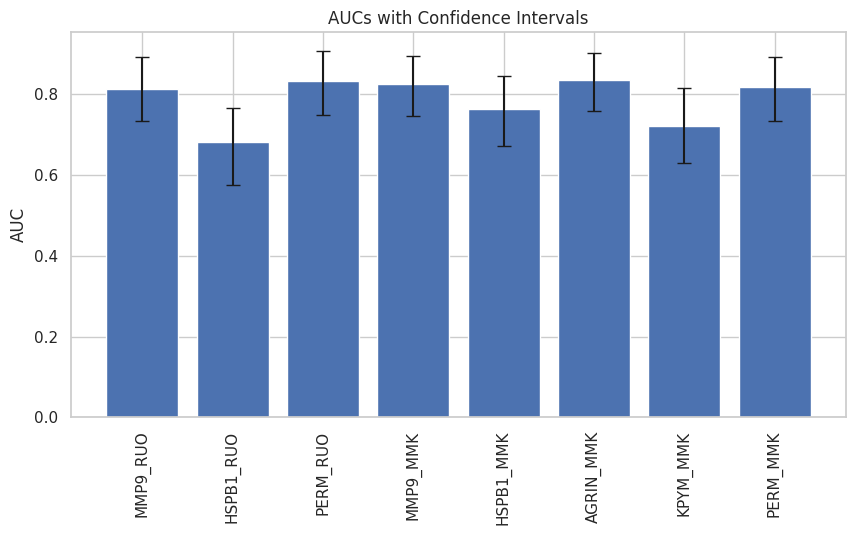

In [54]:
auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(models, aucs, yerr=yerr, capsize=5, align='center')
plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals')
plt.show()